Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN Assgnmt/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN Assgnmt/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


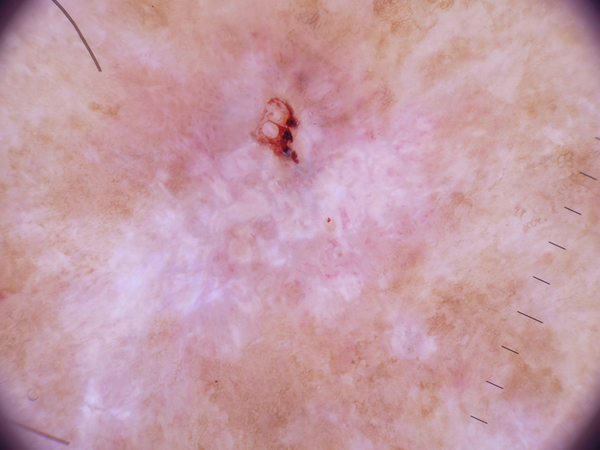

In [ ]:
# Let's visualize one image first, to verify it is working or not.
basal_cell_carcinoma = list(data_dir_train.glob('basal cell carcinoma/*'))
PIL.Image.open(str(basal_cell_carcinoma[1]))

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset="training",
                                                               image_size=(img_height,img_width),
                                                               seed=123)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset="validation",
                                                               image_size=(img_height,img_width),
                                                               seed=123)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

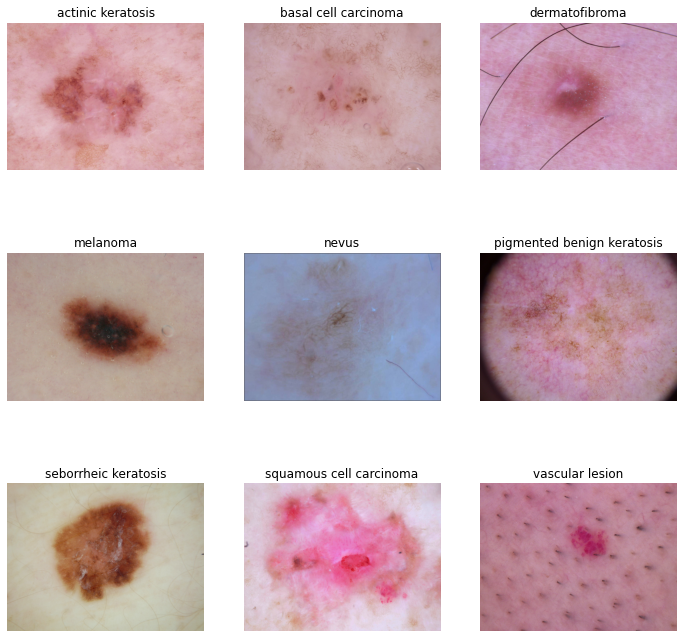

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


plt.figure(figsize=(12, 12))
for i in range(len(class_names)):
  ax = plt.subplot(3, 3, i + 1)
  image_list = list(data_dir_train.glob(class_names[i] + '/*.jpg'))
  plt.imshow(mpimg.imread(image_list[0]))                    # Displaying one instance of all 9 classes.
  plt.title(class_names[i])
  plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [ ]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size. 
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size. 
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size. 
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 141s 842ms/step - loss: 1.7919 - accuracy: 0.3305 - val_loss: 1.5405 - val_accuracy: 0.3957
Epoch 2/20
169/169 [==============================] - 4s 24ms/step - loss: 1.4133 - accuracy: 0.4722 - val_loss: 1.6757 - val_accuracy: 0.3623
Epoch 3/20
169/169 [==============================] - 4s 24ms/step - loss: 1.2083 - accuracy: 0.5501 - val_loss: 1.1021 - val_accuracy: 0.5917
Epoch 4/20
169/169 [==============================] - 4s 24ms/step - loss: 1.0102 - accuracy: 0.6374 - val_loss: 1.2206 - val_accuracy: 0.5501
Epoch 5/20
169/169 [==============================] - 4s 24ms/step - loss: 0.8816 - accuracy: 0.6816 - val_loss: 0.9671 - val_accuracy: 0.6548
Epoch 6/20
169/169 [==============================] - 4s 24ms/step - loss: 0.6860 - accuracy: 0.7535 - val_loss: 0.8763 - val_accuracy: 0.7023
Epoch 7/20
169/169 [==============================] - 4s 24ms/step - loss: 0.5759 - accuracy: 0.7971 - val_loss: 0.7785 - val_accuracy: 0.7

### Visualizing training results

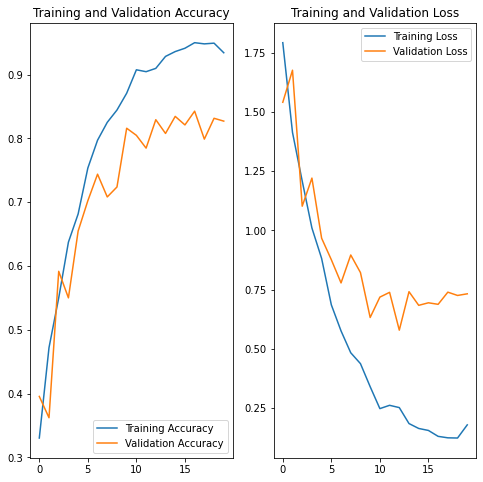

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [25]:
oss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 0s 11ms/step - loss: 0.7325 - accuracy: 0.8270
Accuracy:  0.9532641172409058
Validation Accuracy:  0.8270230293273926
Loss:  [1.7918962240219116, 1.4132916927337646, 1.2082886695861816, 1.0101696252822876, 0.8816301822662354, 0.6859791278839111, 0.575946569442749, 0.4837316870689392, 0.43790754675865173, 0.3406684994697571, 0.24817734956741333, 0.2621293365955353, 0.2525089681148529, 0.1851085126399994, 0.16444097459316254, 0.15606874227523804, 0.1311706006526947, 0.12497618049383163, 0.12407740950584412, 0.17962710559368134]
Validation Loss 0.7324771285057068


**Observation:**

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as Overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process.


*   Data augmentation:
*   Dropouts: bold text

**Data augmentation:**

Data augmentation takes the approach of generating additional training data from our existing examples by augmenting them using random transformations that yield believable looking images. This helps expose the model to more aspects of the data and generalize better.

Dropouts:

When we apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [26]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

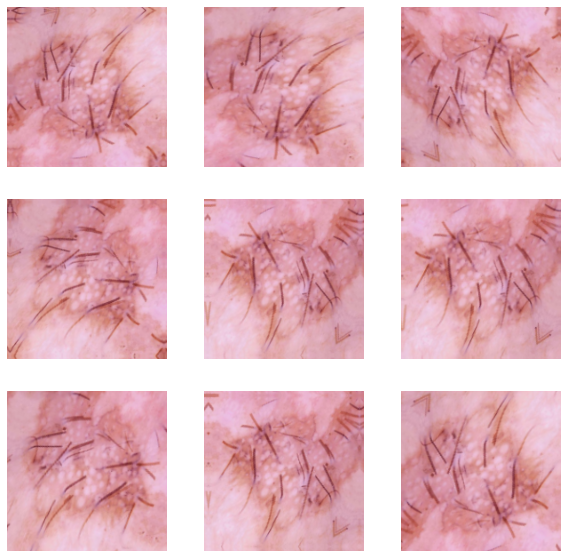

In [27]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

### Training the model

In [31]:
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [32]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   )

Epoch 1/20
169/169 [==============================] - 21s 110ms/step - loss: 1.8714 - accuracy: 0.2888 - val_loss: 1.5824 - val_accuracy: 0.3927
Epoch 2/20
169/169 [==============================] - 18s 106ms/step - loss: 1.5644 - accuracy: 0.3971 - val_loss: 1.4092 - val_accuracy: 0.4321
Epoch 3/20
169/169 [==============================] - 18s 107ms/step - loss: 1.4576 - accuracy: 0.4349 - val_loss: 1.4341 - val_accuracy: 0.4610
Epoch 4/20
169/169 [==============================] - 18s 106ms/step - loss: 1.4195 - accuracy: 0.4473 - val_loss: 1.3594 - val_accuracy: 0.4729
Epoch 5/20
169/169 [==============================] - 18s 105ms/step - loss: 1.3615 - accuracy: 0.4705 - val_loss: 1.2657 - val_accuracy: 0.5145
Epoch 6/20
169/169 [==============================] - 18s 105ms/step - loss: 1.2938 - accuracy: 0.5076 - val_loss: 1.3099 - val_accuracy: 0.4959
Epoch 7/20
169/169 [==============================] - 18s 105ms/step - loss: 1.2638 - accuracy: 0.5189 - val_loss: 1.2377 - val_ac

### Visualizing the results

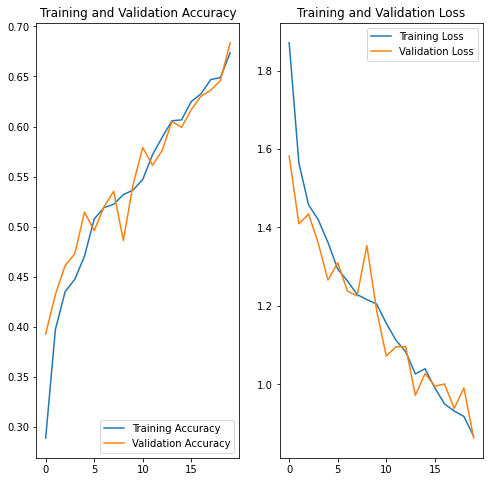

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

You can see there were huge difference in train and test accuracy without applying augmentation which you can say as overfitting. But after applying augmentation accuracy for train and test are better.

In [34]:
# Check the evidence of model is overfit or underfit by comparing previous and present model. 
# Your code goes here
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 1s 32ms/step - loss: 0.8628 - accuracy: 0.6837
Accuracy:  0.7129080295562744
Validation Accuracy:  0.6837416291236877
Loss:  0.7635730504989624
Validation Loss 0.8627867102622986


There is a change in model accuracy <br>
Accuracy:  0.95326<br>
Validation Accuracy:  0.827023<br>
Loss:  0.179<br>
Validation Loss 0.732477

### Present model is:<br>
Accuracy:  0.71291<br>
Validation Accuracy:  0.683741<br>
Loss:  0.7636<br>
Validation Loss 0.862786

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 576x360 with 0 Axes>

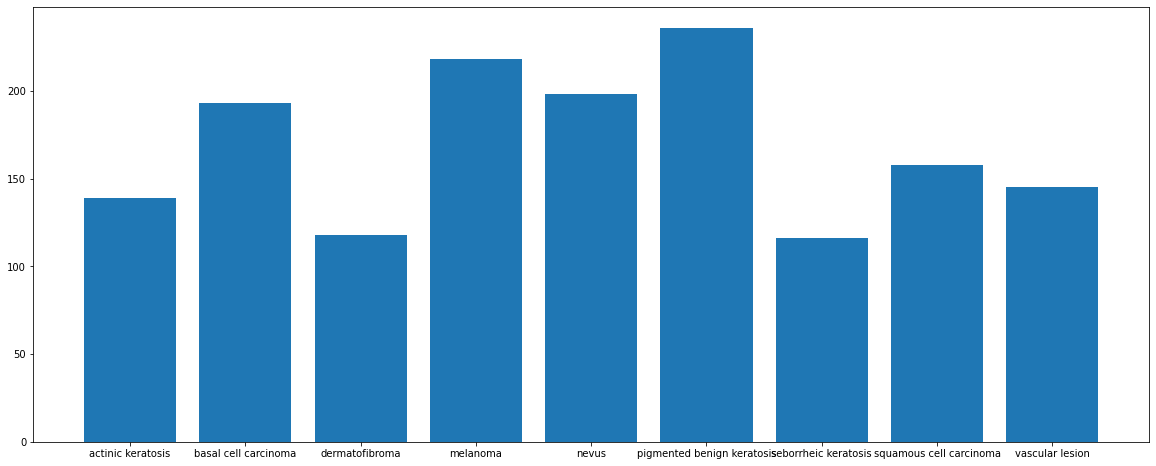

In [35]:
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(8, 5))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

In [36]:
## Your code goes here.
for i in class_names:
  sample_count = len(list(data_dir_train.glob(i + '/*.jpg')))
  print(str(i) + " class contains around: " + str(sample_count) + " sample count.")

actinic keratosis class contains around: 114 sample count.
basal cell carcinoma class contains around: 376 sample count.
dermatofibroma class contains around: 95 sample count.
melanoma class contains around: 438 sample count.
nevus class contains around: 357 sample count.
pigmented benign keratosis class contains around: 462 sample count.
seborrheic keratosis class contains around: 77 sample count.
squamous cell carcinoma class contains around: 181 sample count.
vascular lesion class contains around: 139 sample count.


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
**seborrheic keratosis class contains around- It has only 77 sample Counts**
#### - Which classes dominate the data in terms proportionate number of samples?
melanoma class contains around: 438 sample count


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset="/content/drive/MyDrive/CNN Assgnmt/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assgnmt/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F54165C8100>: 100%|██████████| 500/500 [00:27<00:00, 18.51 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assgnmt/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F542C44C430>: 100%|██████████| 500/500 [00:26<00:00, 19.09 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assgnmt/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F542C3F6970>: 100%|██████████| 500/500 [00:19<00:00, 26.29 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assgnmt/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7F54932E15B0>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assgnmt/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F54BBA32F70>: 100%|██████████| 500/500 [01:22<00:00,  6.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assgnmt/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F54930E5160>: 100%|██████████| 500/500 [00:18<00:00, 26.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assgnmt/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5416087610>: 100%|██████████| 500/500 [00:42<00:00, 11.75 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assgnmt/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F542C4E87C0>: 100%|██████████| 500/500 [00:20<00:00, 24.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assgnmt/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F542C4073D0>: 100%|██████████| 500/500 [00:18<00:00, 26.80 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/CNN Assgnmt/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011043.jpg_3016ebaa-7586-45f6-9f60-8d051473d716.jpg',
 '/content/drive/MyDrive/CNN Assgnmt/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_0cdde772-7070-4364-9b12-3bdf393a3a34.jpg',
 '/content/drive/MyDrive/CNN Assgnmt/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010917.jpg_048b9608-5a7d-45e8-b40a-602d9414aa37.jpg',
 '/content/drive/MyDrive/CNN Assgnmt/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010860.jpg_b44525b0-6631-42db-95c2-3a2b03337540.jpg',
 '/content/drive/MyDrive/CNN Assgnmt/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010866.jpg_fe5bf541-a56e-4d3a-8d5a-a9fc65e458c1.jpg',
 '/content/drive/MyDrive/CNN Assgnmt/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011095.jpg_a314d4ca-f794-46b8-b823-a3aeb5f04b1d.jpg',
 '/content/drive/MyDrive/CNN Assgn

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [45]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [47]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [48]:
new_df['Label'].value_counts()

seborrheic keratosis          1000
melanoma                      1000
nevus                         1000
basal cell carcinoma          1000
pigmented benign keratosis    1000
dermatofibroma                1000
actinic keratosis             1000
squamous cell carcinoma       1000
vascular lesion               1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [51]:
data_dir_train="/content/drive/MyDrive/CNN Assgnmt/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [53]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [55]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 54s 58ms/step - loss: 1.6396 - accuracy: 0.3728 - val_loss: 1.3773 - val_accuracy: 0.4833
Epoch 2/50
281/281 [==============================] - 7s 25ms/step - loss: 1.1881 - accuracy: 0.5615 - val_loss: 1.0919 - val_accuracy: 0.6213
Epoch 3/50
281/281 [==============================] - 7s 24ms/step - loss: 0.8750 - accuracy: 0.6876 - val_loss: 0.8556 - val_accuracy: 0.6969
Epoch 4/50
281/281 [==============================] - 7s 24ms/step - loss: 0.6513 - accuracy: 0.7711 - val_loss: 0.7459 - val_accuracy: 0.7566
Epoch 5/50
281/281 [==============================] - 7s 24ms/step - loss: 0.4860 - accuracy: 0.8255 - val_loss: 0.5861 - val_accuracy: 0.8109
Epoch 6/50
281/281 [==============================] - 7s 24ms/step - loss: 0.3625 - accuracy: 0.8738 - val_loss: 0.6250 - val_accuracy: 0.8020
Epoch 7/50
281/281 [==============================] - 7s 24ms/step - loss: 0.2895 - accuracy: 0.8956 - val_loss: 0.5489 - val_accuracy: 0.835

#### **Todo:**  Visualize the model results

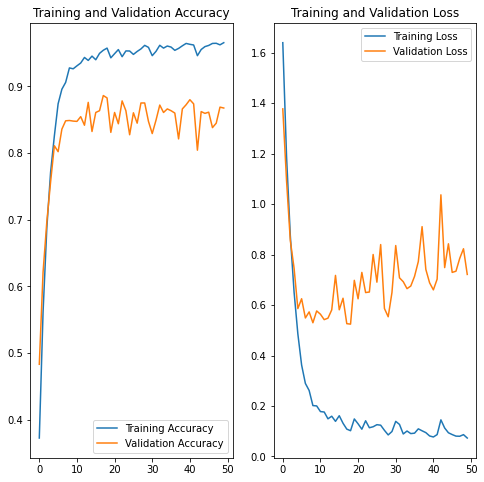

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


71/71 [==============================] - 1s 11ms/step - loss: 0.7214 - accuracy: 0.8674
Accuracy:  0.9719750881195068
Validation Accuracy:  0.8673787117004395
Loss:  0.05980655178427696
Validation Loss 0.7214127779006958


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



##Modal Summary
There is a change in model accuracy<br>
**Apoche=20<br>**
Accuracy: 0.95326<br>
Validation Accuracy: 0.827023<br>
Loss: 0.179<br>
Validation Loss 0.732477<br>

Present model is:<br>
Accuracy: 0.71291<br>
Validation Accuracy: 0.683741<br>
Loss: 0.7636<br>
Validation Loss 0.862786

**For epoche==50**

Accuracy:  0.971975<br>
Validation Accuracy:  0.86737<br>
Loss:  0.0598<br>
Validation Loss 0.7214<br>


##Analysis

*   Yes, The Current iteration we have got better accurace for train and test datasets.
*   In case of the trainig dataset we got the accuracy of 97.197% and for the test dataset it is 86.737%.
*   As the training loss decreases with epochs the validation loss also decreases.
*   The loss for the training dataset and test dataset is observed as 0.05 and 0.72 for 50 epochs.


